# Notebook to examine the temporal variability associated with numerical mixing for Figs. 7-8, which deals with analysis of the tracer budgets.

In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as tick
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.dates as mdates
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

In [2]:
# Open all output from 60 min, 30 min, 10 min frequency

#Tendency - s^2, s'^2, \partial_t(sbar^2)V, and 2sbar(sprime) terms 
ds2dt = np.load('/d2/home/dylan/JAMES/budget_outputs/tendency/ds2dt_parent_ver1_2010.npy')
dsprime2dt = np.load('/d2/home/dylan/JAMES/budget_outputs/tendency/dsprime2dt_ver1_parent_2010.npy')
dsbar2dt = np.load('/d2/home/dylan/JAMES/budget_outputs/tendency/dsbar2dt_parent_ver1_2010.npy')
dsbarsprimedt = np.load('/d2/home/dylan/JAMES/budget_outputs/tendency/dsbarsprimedt1_parent_ver1_2010.npy')

#Advection - 
s2_advection = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/advection/saltsquareadv_parent_ver1_2010_*.nc').__xarray_dataarray_variable__.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_advection = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/advection/saltvaradv_parent_ver1_2010_*.nc').__xarray_dataarray_variable__.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sbarsprime_advection = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/advection/2sbarsprime_advection_ver1_2010_*.nc')['2sbarprime_advection'].sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sbar2_advection = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/advection/sbar2_advection_ver1_2010_*.nc').sbar2_advection.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

#Surface
s2_surface = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/surface_fluxes/s2flux_ver1_2010_*.nc').s2flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_surface = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/surface_fluxes/sprime2flux_ver1_2010_*.nc').sprime2flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
surface_extra = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/surface_fluxes/extra_ver1_2010_*.nc').surface_fluxes_extra.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

#Online resolved and numerical mixing
chi_online = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/chi_online_ver1_2010_*.nc').chi_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
chi_online_child = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/chi_online_nested_2010_*.nc').chi_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
mnum_online_child = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/mnum_online_nested_2010_*.nc').mnum_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))
mnum_online = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/mixing/mnum_online_ver1_2010_*.nc').mnum_online.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

#Horizontal diffusive fluxes
#Boundary area integrals 
# s2_diff_flux_parent = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/horz_terms/s2_horz/s2_horz_diff_parent_*.nc').s2_diff_flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
# sprime2_diff_flux_parent = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/horz_terms/sprime2_horz/sprime2_horz_diff_parent_*.nc').s2_diff_flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
# sbarsprime_diff_flux = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/horz_terms/sbarsprime_hdiffusion_60min_*.nc').sbarsprime_diff_flux.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
#Volume integrals - right way to do it. 
s2_diff_flux_parent = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/budget_recalcs/60min/hdiffusion_vol/s2_hdiffusion_60min_*.nc').s2_diff_flux
sprime2_diff_flux_parent = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/budget_recalcs/60min/hdiffusion_vol/sprime2_hdiffusion_60min_*.nc').sprime2_diff_flux
sbarsprime_diff_flux = xr.open_mfdataset('/d2/home/dylan/JAMES/revised_submission/budget_recalcs/60min/hdiffusion_vol/sbarsprime_hdiffusion_60min_*.nc').sbarsprime_diff_flux

#Horizontal mixing 
chih_parent = xr.open_dataset('/d2/home/dylan/JAMES/revised_submission/horz_terms/chi_horz/chih_parent_hgrad.nc').chih_parent
chi_tot = chih_parent+chi_online

#Offline numerical mixing 
#without horizontal diffusive fluxes and horizontal mixing
# mnum_ss = -(ds2dt+s2_advection+chi_online-s2_surface)
# mnum_sprime2 = -(dsprime2dt+sprime2_advection+chi_online-sprime2_surface)
#with horizontal diffusive fluxes and mixing 
mnum_ss = -(ds2dt+s2_advection+chi_tot-s2_surface-s2_diff_flux_parent)
mnum_sprime2 = -(dsprime2dt+sprime2_advection+chi_tot-sprime2_surface-sprime2_diff_flux_parent)

mnum_diff = -dsbar2dt-dsbarsprimedt-sbarsprime_advection-sbar2_advection+sbarsprime_diff_flux+surface_extra
#without extra diffusive flux
mnum_diff1 = -dsbar2dt-dsbarsprimedt-sbarsprime_advection-sbar2_advection+surface_extra

#Define time for plotting
time = chi_online.ocean_time.values

#Volume-averaged salinity
sbar_parent = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/sbar/sbar_parent_ver1*.nc').sbar.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
s2_vavg = xr.open_dataset('/d2/home/dylan/JAMES/salt2_vavg.nc').salt2_vavg.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]
sprime2_vavg = xr.open_dataset('/d2/home/dylan/JAMES/sprime2_vavg.nc').sprime2_vavg.sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1]

Text(0, 0.5, '[(g kg$^{-1}$)$^2$]')

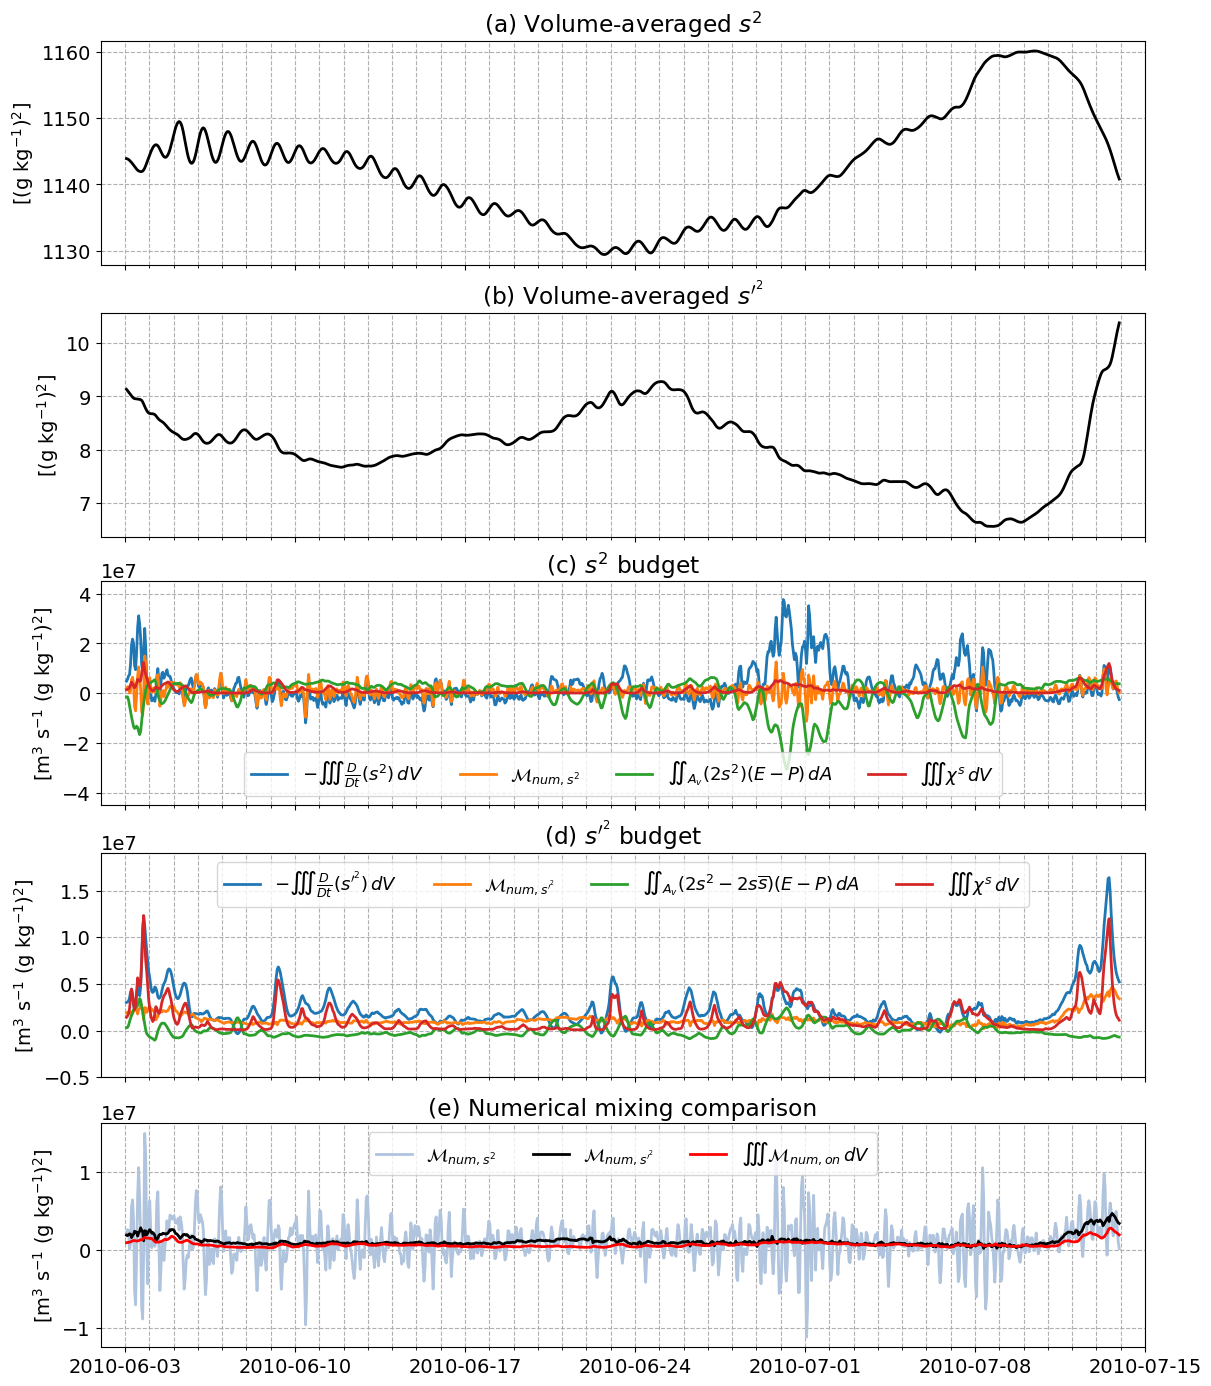

In [3]:
s2_material = ds2dt+s2_advection
sprime2_material = dsprime2dt+sprime2_advection

plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(5,1, figsize = (12,2.75*5), constrained_layout = True, sharey = False)

ax[0].plot(time, s2_vavg, color = 'k', lw = 2)
ax[0].set_xticklabels([])
ax[0].set_title('(a) Volume-averaged $s^2$')

ax[1].plot(time, sprime2_vavg, color = 'k', lw = 2)
ax[1].set_xticklabels([])
ax[1].set_title('(b) Volume-averaged $s^{\prime^2}$')

#salt squared budget
ax[2].plot(time, -s2_material, lw = 2, label = r'$-\iiint \frac{D}{Dt}(s^2) \, dV$')
ax[2].plot(time, mnum_ss, lw = 2, label = r'$\mathcal{M}_{num, s^2}$')
ax[2].plot(time, s2_surface, lw = 2, label = r'$\iint_{A_v} (2s^2)(E-P) \, dA$')
ax[2].plot(time, chi_tot, lw = 2, label = r'$\iiint \chi^s \, dV$')
ax[2].set_ylim(-4.5e7,4.5e7)
ax[2].set_title(r'(c) $s^2$ budget')
ax[2].legend(loc = 'lower center', ncol = 4, fontsize = 13)
ax[2].set_xticklabels([])

#volum-mean salinity variance budget
ax[3].plot(time, -sprime2_material, lw = 2, label = r'$-\iiint \frac{D}{Dt}(s^{\prime^2}) \, dV$')
ax[3].plot(time, mnum_sprime2, lw = 2, label = r'$\mathcal{M}_{num, s^{\prime^2}}$')
ax[3].plot(time, sprime2_surface, lw = 2, label = r'$\iint_{A_v} (2s^2-2s \overline{s})(E-P) \, dA$')
ax[3].plot(time, chi_tot, lw = 2, label = r'$\iiint \chi^s \, dV$')
ax[3].set_ylim(-.5e7,1.9e7)
ax[3].set_title(r'(d) $s^{\prime^2}$ budget')
ax[3].legend(loc = 'upper center', ncol = 4, fontsize = 13)
ax[3].set_xticklabels([])

ax[4].plot(time, mnum_ss, color = 'lightsteelblue', lw = 2, label = r'$\mathcal{M}_{num, s^2}$')
ax[4].plot(time, mnum_sprime2, lw = 2, color = 'k', label = r'$\mathcal{M}_{num, s^{\prime^2}}$')
ax[4].plot(time, mnum_online, lw = 2, color = 'r', label = '$\iiint \mathcal{M}_{num, on} \, dV$')
ax[4].set_title('(e) Numerical mixing comparison')
ax[4].legend(loc = 'upper center', ncol = 3, fontsize = 13)

#Format the date-ticks
myFmt = mdates.DateFormatter("%Y-%m-%d")
dates = ['2010-06-03', '2010-06-10', '2010-06-17', '2010-06-24',
         '2010-07-01', '2010-07-08', '2010-07-15']
#Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]
for i in range(5):
    ax[i].xaxis.set_major_formatter(myFmt)
    ax[i].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
    ax[i].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
    ax[i].set_xticks(ticks = dates)
    ax[i].grid(linestyle = '--')
    ax[i].xaxis.set_minor_locator(mdates.DayLocator())
    minor_locator = AutoMinorLocator(7)
    ax[i].yaxis.grid(True, linestyle = '--')
    ax[i].xaxis.set_minor_locator(minor_locator)
    ax[i].xaxis.grid(True, which = 'both', linestyle = '--')
ax[i].set_xlabel('')
for i in range(4):
    ax[i].set_xticklabels([])

ax[0].set_ylabel(r'[(g kg$^{-1}$)$^2$]')
ax[1].set_ylabel(r'[(g kg$^{-1}$)$^2$]')
# plt.savefig('figures/budget_comparison_material.jpg', dpi = 300, bbox_inches='tight')

# Now add in wind stress and wind speed 

In [4]:
# Open coarse simulation output and spatially average wind stress and wind speed over the child grid. 
# Open the parent and child models 
path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/non-nest/ver1/1hr/ocean_avg_0000*.nc')
ds_avg = xroms.open_mfnetcdf(path)
ds_avg, grid_avg = xroms.roms_dataset(ds_avg)

#Parent model slices
xislice = slice(271,404)
etaslice = slice(31,149)

In [5]:
su_rho = grid_avg.interp(ds_avg.sustr, 'X', boundary = 'extend') #boundary = extend is a no gradient condition
sv_rho = grid_avg.interp(ds_avg.svstr, 'Y', boundary = 'extend')

su_ew = su_rho*np.cos(ds_avg.angle)-(sv_rho*np.sin(ds_avg.angle)) #East-west
sv_ns = sv_rho*np.cos(ds_avg.angle)+(su_rho*np.sin(ds_avg.angle)) #North-south

su_avg = su_ew.isel(eta_rho = etaslice, xi_rho = xislice).mean(['eta_rho', 'xi_rho']).sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1].load()
sv_avg = sv_ns.isel(eta_rho = etaslice, xi_rho = xislice).mean(['eta_rho', 'xi_rho']).sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1].load()

In [6]:
# Wind speed 
uwind_ew = ds_avg.Uwind*np.cos(ds_avg.angle)-(ds_avg.Uwind*np.sin(ds_avg.angle)) #East-west
vwind_ns = ds_avg.Vwind*np.cos(ds_avg.angle)+(ds_avg.Vwind*np.sin(ds_avg.angle)) #North-south

uwind_avg = uwind_ew.isel(eta_rho = etaslice, xi_rho = xislice).mean(['eta_rho', 'xi_rho']).sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1].load()
vwind_avg = vwind_ns.isel(eta_rho = etaslice, xi_rho = xislice).mean(['eta_rho', 'xi_rho']).sel(ocean_time = slice('2010-06-03', '2010-07-13'))[1:-1].load()

wndspeed = np.sqrt(uwind_avg**2+vwind_avg**2)

# Now make a test plot with two y-axes, wind stress on the LHS and wind speed on the RHS

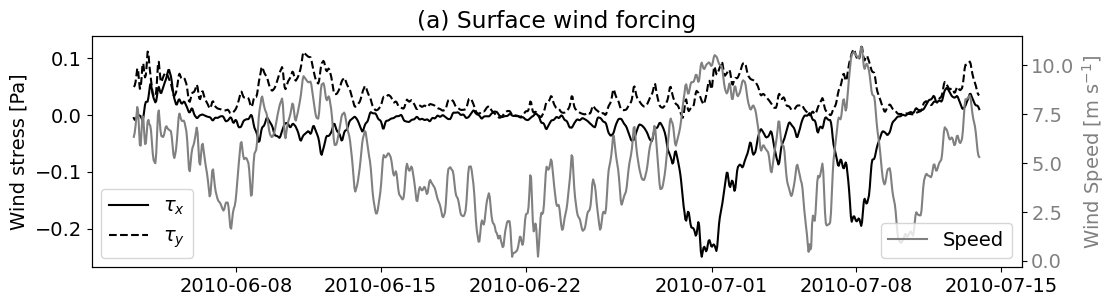

In [7]:
fig, ax = plt.subplots(1, figsize = (12,3))

ax.plot(time, su_avg, c = 'k',label = r'$\tau_x$')
ax.plot(time, sv_avg, c = 'k', ls = '--', label = r'$\tau_y$')
ax.set_ylabel('Wind stress [Pa]')
ax.legend()
ax.set_title('(a) Surface wind forcing')

ax11 = ax.twinx()
ax11.plot(time, wndspeed, c= 'grey', label = 'Speed')
ax11.tick_params(axis="y", labelcolor= 'grey')
ax11.set_ylabel(r'Wind Speed [m s$^{-1}$]', color= 'grey')
ax11.legend(loc = 'lower right')


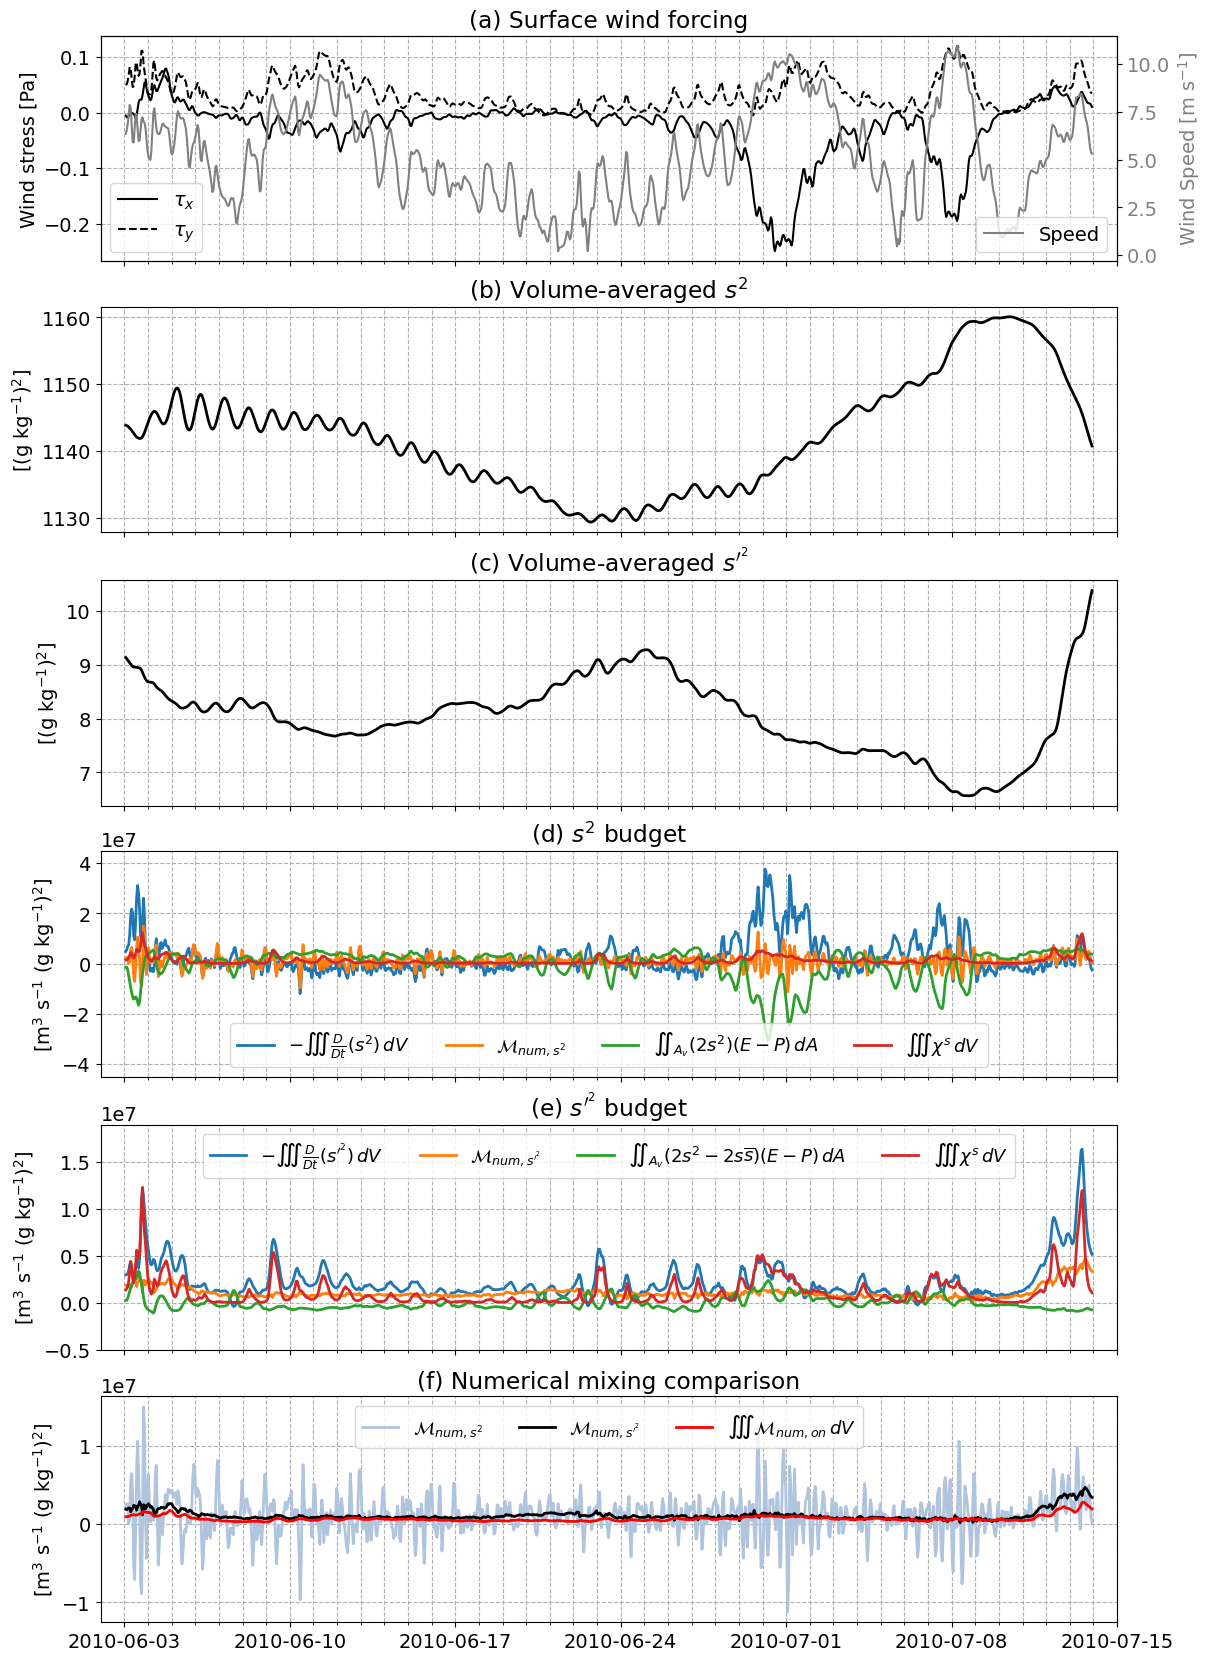

In [16]:
s2_material = ds2dt+s2_advection
sprime2_material = dsprime2dt+sprime2_advection

plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(6,1, figsize = (12,2.75*6), constrained_layout = True, sharey = False)

ax[0].plot(time, su_avg, c = 'k',label = r'$\tau_x$')
ax[0].plot(time, sv_avg, c = 'k', ls = '--', label = r'$\tau_y$')
ax[0].set_ylabel('Wind stress [Pa]')
ax[0].legend()
ax[0].set_title('(a) Surface wind forcing')
ax[0].set_xticklabels([])

ax11 = ax[0].twinx()
ax11.plot(time, wndspeed, c= 'grey', label = 'Speed')
ax11.tick_params(axis="y", labelcolor= 'grey')
ax11.set_ylabel(r'Wind Speed [m s$^{-1}$]', color= 'grey')
ax11.legend(loc = 'lower right')

ax[1].plot(time, s2_vavg, color = 'k', lw = 2)
ax[1].set_xticklabels([])
ax[1].set_title('(b) Volume-averaged $s^2$')

ax[2].plot(time, sprime2_vavg, color = 'k', lw = 2)
ax[2].set_xticklabels([])
ax[2].set_title('(c) Volume-averaged $s^{\prime^2}$')
# np.abs(s2_diff_flux_parent).plot(ax = ax[0], lw = 2, color = 'grey', label = r'$\iint_{A_l} \kappa_H \nabla_H s^{2} \cdot \hat{\mathbf{n}} \, dA$')
# np.abs(sprime2_diff_flux_parent).plot(ax = ax[0], lw = 2, color = 'b', label = r'$\iint_{A_l} \kappa_H \nabla_H s^{\prime^2} \cdot \hat{\mathbf{n}} \, dA$')

ax[3].plot(time, -s2_material, lw = 2, label = r'$-\iiint \frac{D}{Dt}(s^2) \, dV$')
ax[3].plot(time, mnum_ss, lw = 2, label = r'$\mathcal{M}_{num, s^2}$')
ax[3].plot(time, s2_surface, lw = 2, label = r'$\iint_{A_v} (2s^2)(E-P) \, dA$')
# ax[2].plot(time, s2_diff_flux_parent[1:-1], lw = 2, label = r'$\iint_{A_l} \kappa_H \nabla_H s^{2} \cdot \hat{\mathbf{n}} \, dA$')

ax[3].plot(time, chi_tot, lw = 2, label = r'$\iiint \chi^s \, dV$')


ax[3].set_ylim(-4.5e7,4.5e7)
ax[3].set_title(r'(d) $s^2$ budget')
ax[3].legend(loc = 'lower center', ncol = 4, fontsize = 13)
ax[3].set_xticklabels([])

ax[4].plot(time, -sprime2_material, lw = 2, label = r'$-\iiint \frac{D}{Dt}(s^{\prime^2}) \, dV$')
ax[4].plot(time, mnum_sprime2, lw = 2, label = r'$\mathcal{M}_{num, s^{\prime^2}}$')
ax[4].plot(time, sprime2_surface, lw = 2, label = r'$\iint_{A_v} (2s^2-2s \overline{s})(E-P) \, dA$')
ax[4].plot(time, chi_tot, lw = 2, label = r'$\iiint \chi^s \, dV$')
ax[4].set_ylim(-.5e7,1.9e7)
ax[4].set_title(r'(e) $s^{\prime^2}$ budget')
ax[4].legend(loc = 'upper center', ncol = 4, fontsize = 13)
ax[4].set_xticklabels([])

ax[5].plot(time, mnum_ss, color = 'lightsteelblue', lw = 2, label = r'$\mathcal{M}_{num, s^2}$')
ax[5].plot(time, mnum_sprime2, lw = 2, color = 'k', label = r'$\mathcal{M}_{num, s^{\prime^2}}$')
ax[5].plot(time, mnum_online, lw = 2, color = 'r', label = '$\iiint \mathcal{M}_{num, on} \, dV$')
ax[5].set_title('(f) Numerical mixing comparison')
ax[5].legend(loc = 'upper center', ncol = 3, fontsize = 13)
# bbox_to_anchor=(1.0, 1.02)
#Format the date-ticks
myFmt = mdates.DateFormatter("%Y-%m-%d")
dates = ['2010-06-03', '2010-06-10', '2010-06-17', '2010-06-24',
         '2010-07-01', '2010-07-08', '2010-07-15']
#Convert date strings (e.g. 2014-10-18) to datetime
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]
for i in range(6):
    ax[i].xaxis.set_major_formatter(myFmt)
    ax[i].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
    # ax[i].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
    ax[i].set_xticks(ticks = dates)
    ax[i].grid(linestyle = '--')
    ax[i].xaxis.set_minor_locator(mdates.DayLocator())
    minor_locator = AutoMinorLocator(7)
    ax[i].yaxis.grid(True, linestyle = '--')
    ax[i].xaxis.set_minor_locator(minor_locator)
    ax[i].xaxis.grid(True, which = 'both', linestyle = '--')
ax[i].set_xlabel('')
for i in range(5):
    ax[i].set_xticklabels([])

# ax[0].set_ylabel(r'[(g kg$^{-1}$)$^2$]')
ax[1].set_ylabel(r'[(g kg$^{-1}$)$^2$]')
ax[2].set_ylabel(r'[(g kg$^{-1}$)$^2$]')
ax[3].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax[4].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
ax[5].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
    # ax[i].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
plt.savefig('budget_comparison_material.jpg', dpi = 300, bbox_inches='tight')

# Move onto extra terms in the $s^2$ budget 

Text(0, 0.5, '[g kg$^{-1}$]')

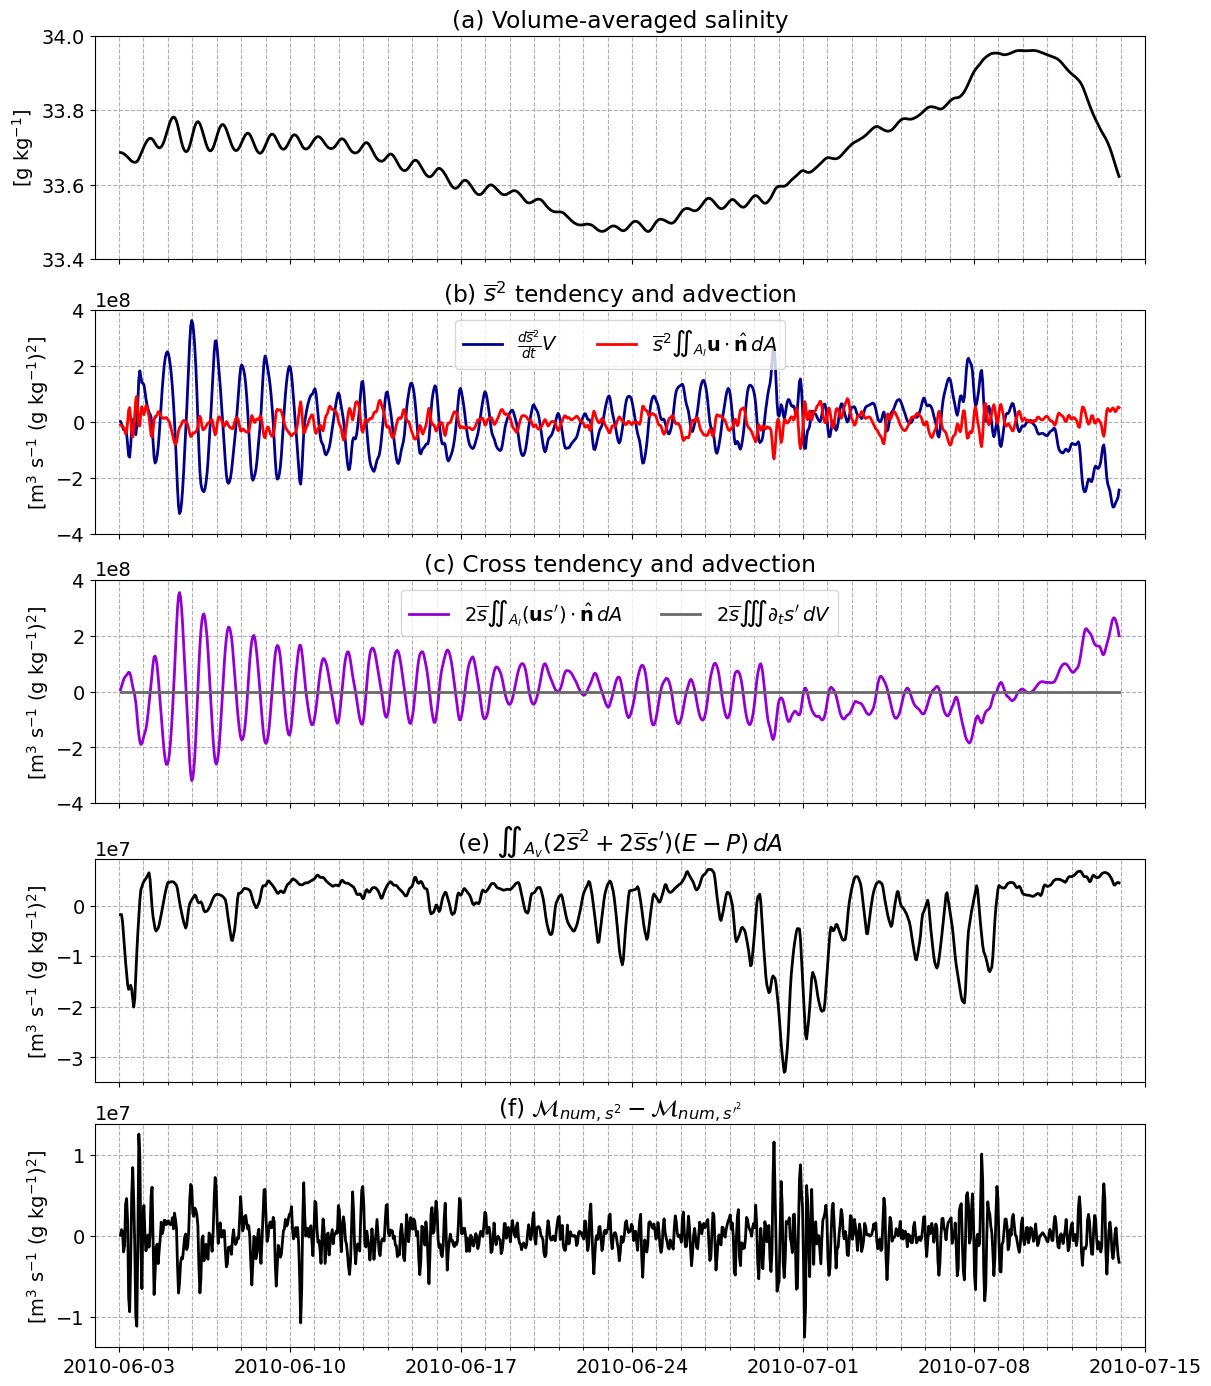

In [8]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(5,1, figsize = (12,2.75*5), constrained_layout = True, sharey = False)

ax[0].plot(time, sbar_parent, color = 'k', lw = 2)
ax[0].set_ylim(33.4, 34)
ax[0].set_title('(a) Volume-averaged salinity')

ax[1].plot(time, dsbar2dt, lw = 2, color = 'darkblue', label = r'$\frac{d\overline{s}^2}{dt}V$')
ax[1].plot(time, sbar2_advection, lw = 2, color = 'r', label = r'$\overline{s}^2 \iint_{A_l} \mathbf{u} \cdot \hat{\mathbf{n}} \, dA$')
ax[1].legend(loc = 'upper center', ncol = 2)
ax[1].set_title(r'(b) $\overline{s}^2$ tendency and advection')
ax[1].set_ylim(-4e8,4e8)

ax[2].plot(time, sbarsprime_advection, color = 'darkviolet', lw = 2, label = r'$2\overline{s} \iint_{A_l} (\mathbf{u}s^{\prime}) \cdot \hat{\mathbf{n}} \, dA$')
ax[2].plot(time, dsbarsprimedt, color = 'dimgrey', lw = 2, label = r'$2\overline{s}\iiint \partial_t s^\prime \, dV$')
ax[2].legend(loc = 'upper center', ncol = 2)
ax[2].set_title(r'(c) Cross tendency and advection')
ax[2].set_ylim(-4e8,4e8)

ax[3].plot(time, surface_extra, lw = 2, color = 'k')
ax[3].set_title(r'(e) $\iint_{A_v} (2 \overline{s}^2+2\overline{s}s^\prime)(E-P) \, dA$')

ax[4].plot(time, mnum_diff, lw = 2, color = 'k')
ax[4].set_title(r'(f) $\mathcal{M}_{num, s^2} - \mathcal{M}_{num, s^{\prime^2}}$')

for i in range(5):
    ax[i].xaxis.set_major_formatter(myFmt)
    ax[i].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
    ax[i].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
    ax[i].set_xticks(ticks = dates)
    ax[i].grid(linestyle = '--')
    ax[i].xaxis.set_minor_locator(mdates.DayLocator())
    ax[i].yaxis.grid(True, linestyle = '--')
    ax[i].xaxis.set_minor_locator(minor_locator)
    ax[i].xaxis.grid(True, which = 'both', linestyle = '--')
for i in range(4):
    ax[i].set_xticklabels([])
# ax[i+1].set_xlabel('Time [month-day 2010]')

ax[0].set_ylabel('[g kg$^{-1}$]')
# plt.savefig('figures/extra_terms_revised.jpg', dpi = 300, bbox_inches='tight')

# Add in diffusive boundary flux extra term 

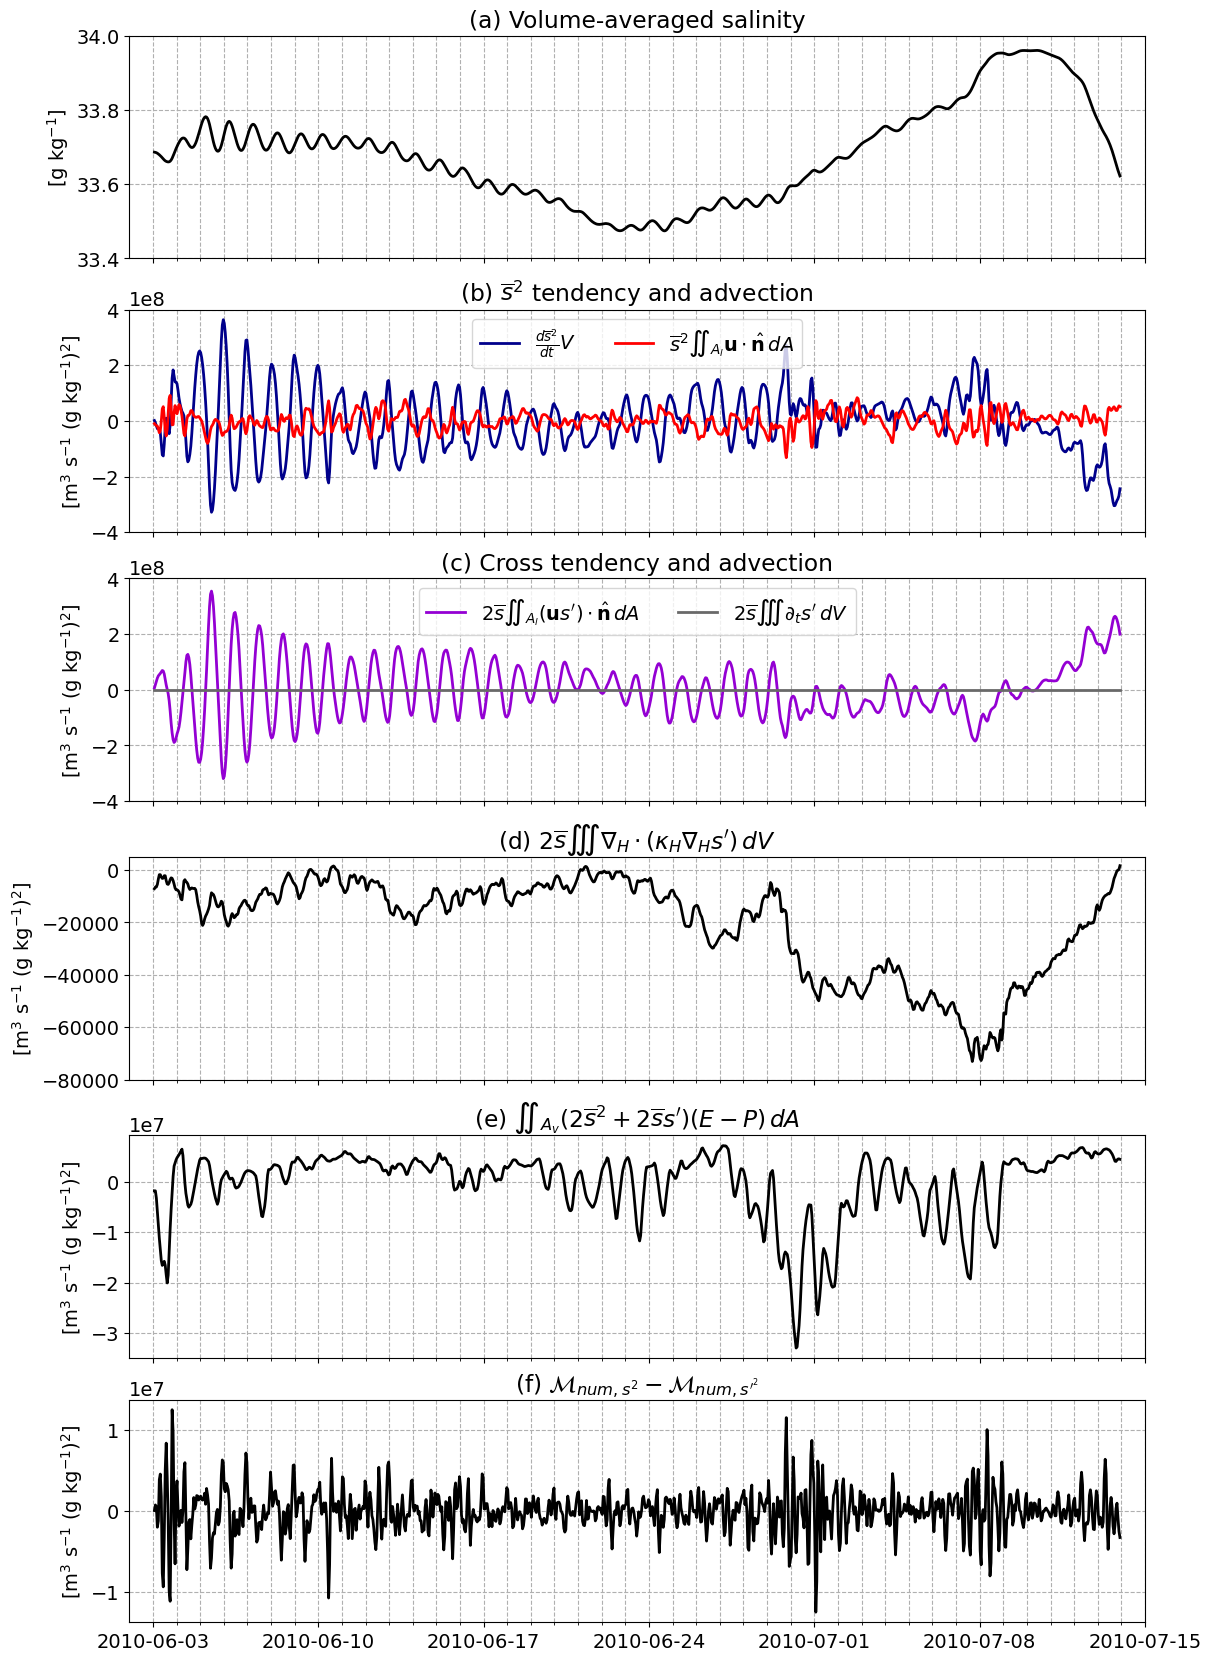

In [15]:
#Version with diffusive term as an area integral
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(6,1, figsize = (12,2.75*6), constrained_layout = True, sharey = False)

ax[0].plot(time, sbar_parent, color = 'k', lw = 2)
ax[0].set_ylim(33.4, 34)
ax[0].set_title('(a) Volume-averaged salinity')

ax[1].plot(time, dsbar2dt, lw = 2, color = 'darkblue', label = r'$\frac{d\overline{s}^2}{dt}V$')
ax[1].plot(time, sbar2_advection, lw = 2, color = 'r', label = r'$\overline{s}^2 \iint_{A_l} \mathbf{u} \cdot \hat{\mathbf{n}} \, dA$')
ax[1].legend(loc = 'upper center', ncol = 2)
ax[1].set_title(r'(b) $\overline{s}^2$ tendency and advection')
ax[1].set_ylim(-4e8,4e8)

ax[2].plot(time, sbarsprime_advection, color = 'darkviolet', lw = 2, label = r'$2\overline{s} \iint_{A_l} (\mathbf{u}s^{\prime}) \cdot \hat{\mathbf{n}} \, dA$')
ax[2].plot(time, dsbarsprimedt, color = 'dimgrey', lw = 2, label = r'$2\overline{s} \iiint \partial_t s^\prime \, dV$')
ax[2].legend(loc = 'upper center', ncol = 2)
ax[2].set_title(r'(c) Cross tendency and advection')
ax[2].set_ylim(-4e8,4e8)

ax[3].plot(time, sbarsprime_diff_flux[1:-1], lw = 2, c = 'k')
ax[3].set_title(r'(d) $2 \overline{s} \iiint \nabla_H \cdot (\kappa_H \nabla_H s^{\prime})  \, dV$')
ax[3].set_ylim(-80000,5000)

ax[4].plot(time, surface_extra, lw = 2, color = 'k')
ax[4].set_title(r'(e) $\iint_{A_v} (2 \overline{s}^2+2\overline{s}s^\prime)(E-P) \, dA$')

ax[5].plot(time, mnum_diff, lw = 2, color = 'k')
ax[5].set_title(r'(f) $\mathcal{M}_{num, s^2} - \mathcal{M}_{num, s^{\prime^2}}$')

for i in range(6):
    ax[i].xaxis.set_major_formatter(myFmt)
    ax[i].set_xlim(datetime(2010,6,2), datetime(2010,7,15))
    ax[i].set_ylabel(r'[m$^3$ s$^{-1}$ (g kg$^{-1}$)$^2$]')
    ax[i].set_xticks(ticks = dates)
    ax[i].grid(linestyle = '--')
    ax[i].xaxis.set_minor_locator(mdates.DayLocator())
    ax[i].yaxis.grid(True, linestyle = '--')
    ax[i].xaxis.set_minor_locator(minor_locator)
    ax[i].xaxis.grid(True, which = 'both', linestyle = '--')
for i in range(5):
    ax[i].set_xticklabels([])
# ax[i+1].set_xlabel('Time [month-day 2010]')

ax[0].set_ylabel('[g kg$^{-1}$]')
plt.savefig('extra_terms_revised.jpg', dpi = 300, bbox_inches='tight')